In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

In [142]:
!pip install tiktoken --quiet

In [143]:
import tiktoken

In [144]:
data = pd.read_csv("../data/telegram_ads_v2.csv")
data.head(10)

,Text,Id
0,деревянная статуэтка 4000 рублей\nигра 400 руб...,"{'platform': 'telegram', 'wall_id': 1525972822..."
1,автокресло britax romer от 6 месяцев до 9 лет ...,"{'platform': 'telegram', 'wall_id': 1525972822..."
2,перчатки christian dior кожаные 8500\n(на одно...,"{'platform': 'telegram', 'wall_id': 1525972822..."
3,"сервиз чайная роза гдр -5500, \nкофейный серви...","{'platform': 'telegram', 'wall_id': 1525972822..."
4,сумка moschino винтаж -20.000 \n\nзабирать на ...,"{'platform': 'telegram', 'wall_id': 1525972822..."
5,"продам телевизор mystery, модель mtv-1922lw. ж...","{'platform': 'telegram', 'wall_id': 1525972822..."
6,шапка-шлем мужская finn flare.\nматериал: нату...,"{'platform': 'telegram', 'wall_id': 1525972822..."
7,парфюм мужской parfums genty.\nпроизводство: р...,"{'platform': 'telegram', 'wall_id': 1525972822..."
8,"1. «искусство древнего мира». дмитриева н.а., ...","{'platform': 'telegram', 'wall_id': 1525972822..."
9,"«лососи, бобры, каланы».\nкнига жака-ива кусто...","{'platform': 'telegram', 'wall_id': 1525972822..."


ChatGPT иногда съедает размер в формате 30*40 (выдаёт просто 3040), возможно, стоит заменить на  30x40  
Но это не точно

In [145]:
# data["Text"].apply(lambda s: re.sub(r'([0-9])\*([0-9])', r'\1\2', s))

In [146]:
def is_selling_text(text):
    for sub in (r'.*прода[еёю]тся.*', r'.*продажа.*', r'.*прода[юм].*'):
        if re.match(sub, text.lower()) is not None:
            return True
    return False

def is_bad_text(text):
    for sub in (r'.*куп(лю|им).*', r'.*сда(м|ю|дим|ется|ётся).*', r'.*аренд[ау].*', r'.*ищ(у|ем).*', r'.*продан(о|а|ы)?.*'):
        if re.match(sub, text.lower()) is not None:
            return True
    return False

def remove_urls(text):
    return

def count_numbers(string):
    string = re.sub(r'([0-9])[.,]([0-9])', r'\1\2', string)
    reg = re.compile('[0-9]+')
    return len(reg.split(string)) - 1

def count_input_tokens(text):
    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
    return len(encoding.encode(text))

In [147]:
data = data[data["Text"].apply(lambda t: not is_bad_text(t))]
data.shape

(170076, 2)

In [148]:
data["Length"] = data.loc[:, "Text"].apply(lambda x: len(list(x.split())))
data = data[data["Length"] >= 5]

In [149]:
data["Nums"] = data.loc[:, "Text"].apply(count_numbers)
data["Tokens"] = data.loc[:, "Text"].apply(count_input_tokens)
data["NumsPerWord"] = data.loc[:, "Nums"] / data.loc[:, "Length"]
data["TokensPerWord"] = data.loc[:, "Tokens"] / data.loc[:, "Length"]

In [150]:
explicit = data[data["Text"].apply(is_selling_text)].copy()
candidates = data[data["Text"].apply(lambda t: not is_selling_text(t))].copy()

explicit.shape, candidates.shape

((59667, 7), (101349, 7))

In [151]:
explicit.head()

,Text,Id,Length,Nums,Tokens,NumsPerWord,TokensPerWord
5,"продам телевизор mystery, модель mtv-1922lw. ж...","{'platform': 'telegram', 'wall_id': 1525972822...",31,5,90,0.161290,2.903226
15,"продам телевизор supra, модель: stv-lc2222wd, ...","{'platform': 'telegram', 'wall_id': 1525972822...",16,5,55,0.312500,3.437500
16,"продаю новогодний венок, 35 см, полностью ручн...","{'platform': 'telegram', 'wall_id': 1525972822...",23,2,63,0.086957,2.739130
35,"продаю две ёлочки, 30 см, полностью ручная раб...","{'platform': 'telegram', 'wall_id': 1525972822...",16,2,46,0.125000,2.875000
45,продается прилесной участок в коттеджном посел...,"{'platform': 'telegram', 'wall_id': 1525972822...",116,10,431,0.086207,3.715517


In [152]:
candidates.head()

,Text,Id,Length,Nums,Tokens,NumsPerWord,TokensPerWord
0,деревянная статуэтка 4000 рублей\nигра 400 руб...,"{'platform': 'telegram', 'wall_id': 1525972822...",12,4,43,0.333333,3.583333
1,автокресло britax romer от 6 месяцев до 9 лет ...,"{'platform': 'telegram', 'wall_id': 1525972822...",29,5,97,0.172414,3.344828
2,перчатки christian dior кожаные 8500\n(на одно...,"{'platform': 'telegram', 'wall_id': 1525972822...",13,1,43,0.076923,3.307692
3,"сервиз чайная роза гдр -5500, \nкофейный серви...","{'platform': 'telegram', 'wall_id': 1525972822...",11,2,40,0.181818,3.636364
4,сумка moschino винтаж -20.000 \n\nзабирать на ...,"{'platform': 'telegram', 'wall_id': 1525972822...",7,1,24,0.142857,3.428571


In [153]:
explicit.drop(labels=explicit[explicit["NumsPerWord"] > 1].index, inplace=True)
candidates.drop(labels=candidates[candidates["NumsPerWord"] > 1].index, inplace=True)

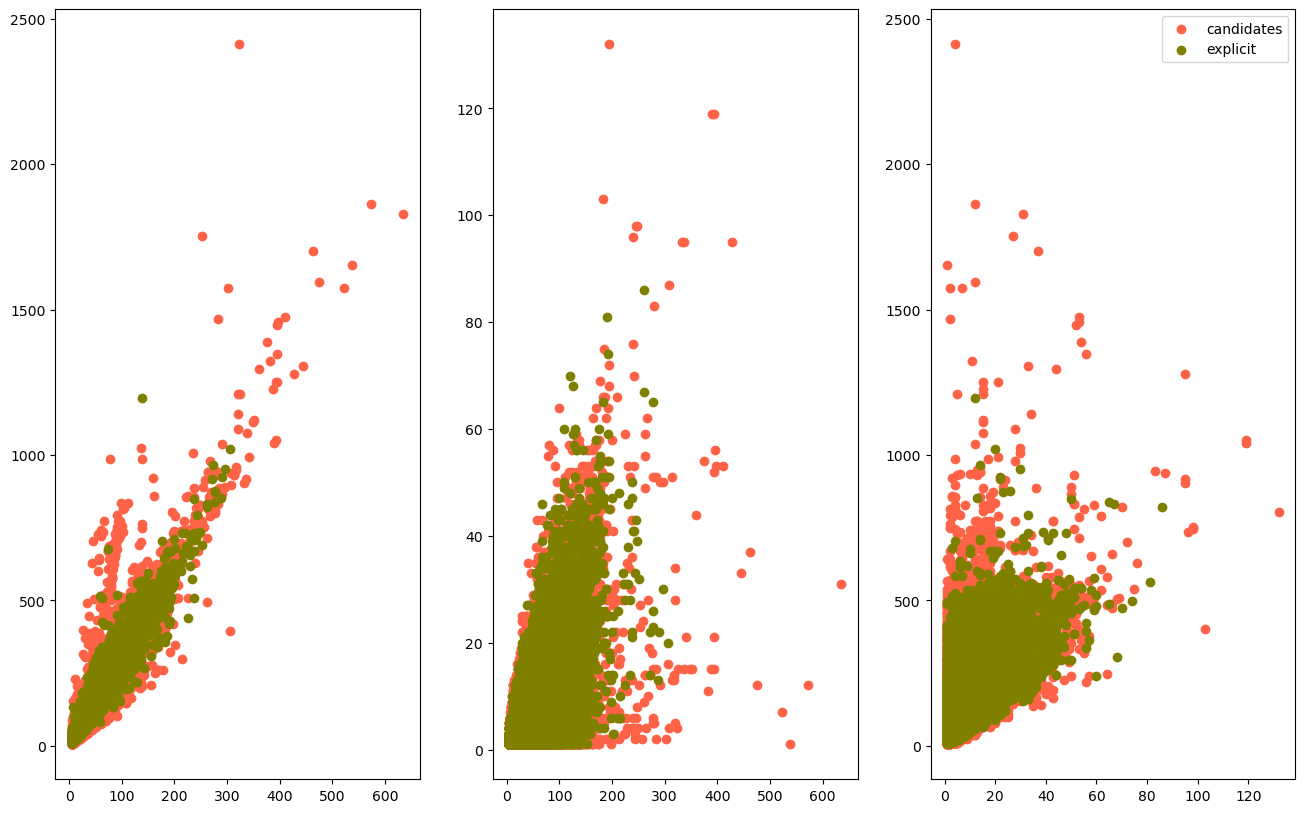

In [154]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 10))
ax0.scatter(candidates["Length"], candidates["Tokens"], color="tomato", label="candidates")
ax1.scatter(candidates["Length"], candidates["Nums"], color="tomato", label="candidates")
ax2.scatter(candidates["Nums"], candidates["Tokens"], color="tomato", label="candidates")

ax0.scatter(explicit["Length"], explicit["Tokens"], color="olive", label="explicit")
ax1.scatter(explicit["Length"], explicit["Nums"], color="olive", label="explicit")
ax2.scatter(explicit["Nums"], explicit["Tokens"], color="olive", label="explicit")

ax0.set_xlabel("Length")
ax0.set_ylabel("Tokens")
ax1.set_xlabel("Length")
ax1.set_ylabel("Numbers")
ax2.set_xlabel("Numbers")
ax2.set_ylabel("Tokens")

plt.legend()
plt.show()

Можно сыграть на распределении отношения количества токенов к количеству слов. Избавившить от откровенных выбросов, распределения явных объяв и кандидатов сблизятся.

In [155]:
tpv_min, tpv_max = explicit["TokensPerWord"].quantile([0.0, 0.999])
tpv_min, tpv_max

(1.4137931034482758, 6.333333333333333)

In [156]:
candidates.drop(labels=candidates[(candidates["TokensPerWord"] > tpv_max) & (candidates["Tokens"] > 500)].index, inplace=True)

На данном датасете большинство объявлений среди кандидатов, имеющих длину(количество токенов) большую, чем максимальная длина(количество токенов) среди явных объявлений - то это, скорее всего, мусор

In [157]:
candidates.drop(labels=candidates[candidates["Tokens"] > explicit["Tokens"].max()].index, inplace=True)
candidates.drop(labels=candidates[candidates["Length"] > explicit["Length"].max()].index, inplace=True)

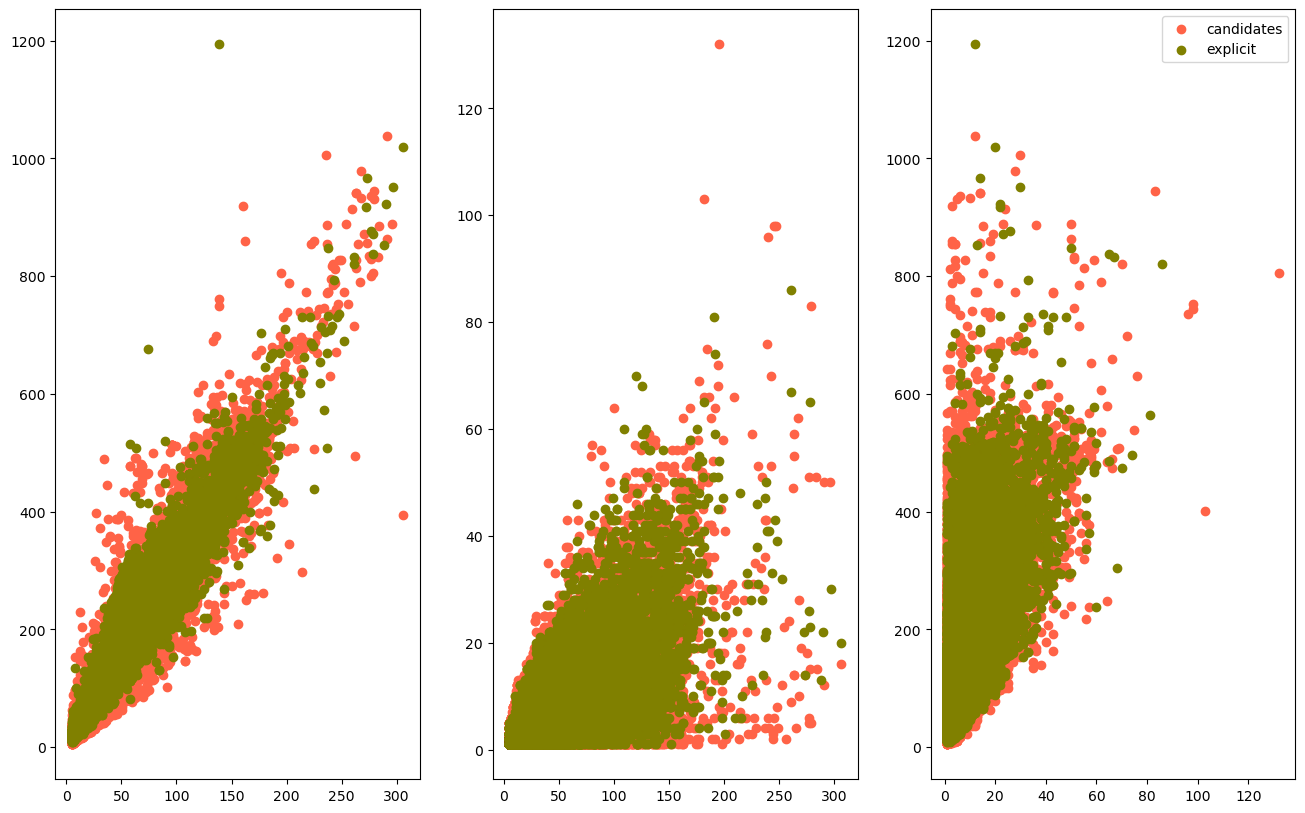

In [158]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 10))
ax0.scatter(candidates["Length"], candidates["Tokens"], color="tomato", label="candidates")
ax1.scatter(candidates["Length"], candidates["Nums"], color="tomato", label="candidates")
ax2.scatter(candidates["Nums"], candidates["Tokens"], color="tomato", label="candidates")

ax0.scatter(explicit["Length"], explicit["Tokens"], color="olive", label="explicit")
ax1.scatter(explicit["Length"], explicit["Nums"], color="olive", label="explicit")
ax2.scatter(explicit["Nums"], explicit["Tokens"], color="olive", label="explicit")

ax0.set_xlabel("Length")
ax0.set_ylabel("Tokens")
ax1.set_xlabel("Length")
ax1.set_ylabel("Numbers")
ax2.set_xlabel("Numbers")
ax2.set_ylabel("Tokens")

plt.legend()
plt.show()

In [159]:
explicit.shape, candidates.shape

((59667, 7), (101199, 7))

In [160]:
explicit.to_csv("../data/explicit_ads.csv", index=False)
candidates.to_csv("../data/implicit_ads.csv", index=False)

При псевдоразметке, скорее всего, лучшая стратегия - брать явные объявления и подмешивать туда в не очень большой пропорции неявные